In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "analysis_random.csv"
df = pd.read_csv(filepath, sep=";")

df_filtered = df[df["numbers_of_steps_to_solve"] != -1]


## Valid/total ratio

In [13]:
ratio = len(df_filtered) / len(df)
print(f"{ratio * 100:.2f}%")


61.23%


## Multiple regression analysis

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump


x = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy']]
y = df_filtered["numbers_of_steps_to_solve"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

dump(model, "sudoku_model.joblib")

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

print("Coefficients:", model.coef_)


Mean Squared Error: 0.3239029520451422
Coefficient of Determination (R^2): 0.9979168983614531
Coefficients: [ 0.007625   -0.98473374 -0.00217344]


## Combining columns

In [15]:
df_filtered['entropy_and_coverage_01'] = df_filtered['initial_numbers_entropy'] + 0.1 * df_filtered["number_of_initial_values"] / 81
df_filtered['entropy_and_coverage_005'] = df_filtered['initial_numbers_entropy'] + 0.05 * df_filtered["number_of_initial_values"] / 81

df_filtered = df_filtered[['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy', 'entropy_and_coverage_01', 'entropy_and_coverage_005', 'numbers_of_steps_to_solve']]

C:\Users\adria\AppData\Local\Temp\ipykernel_8684\1016047142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['entropy_and_coverage_01'] = df_filtered['initial_numbers_entropy'] + 0.1 * df_filtered["number_of_initial_values"] / 81
C:\Users\adria\AppData\Local\Temp\ipykernel_8684\1016047142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['entropy_and_coverage_005'] = df_filtered['initial_numbers_entropy'] + 0.05 * df_filtered["number_of_initial_values"] / 81


## Correlation test

In [16]:
correlation_matrix = df_filtered.corr()
correlation_matrix.iloc[-1][:-1]

sum_of_candidates           0.943637
number_of_initial_values   -0.998806
initial_numbers_entropy    -0.764623
entropy_and_coverage_01    -0.893181
entropy_and_coverage_005   -0.846018
Name: numbers_of_steps_to_solve, dtype: float64

## Plots

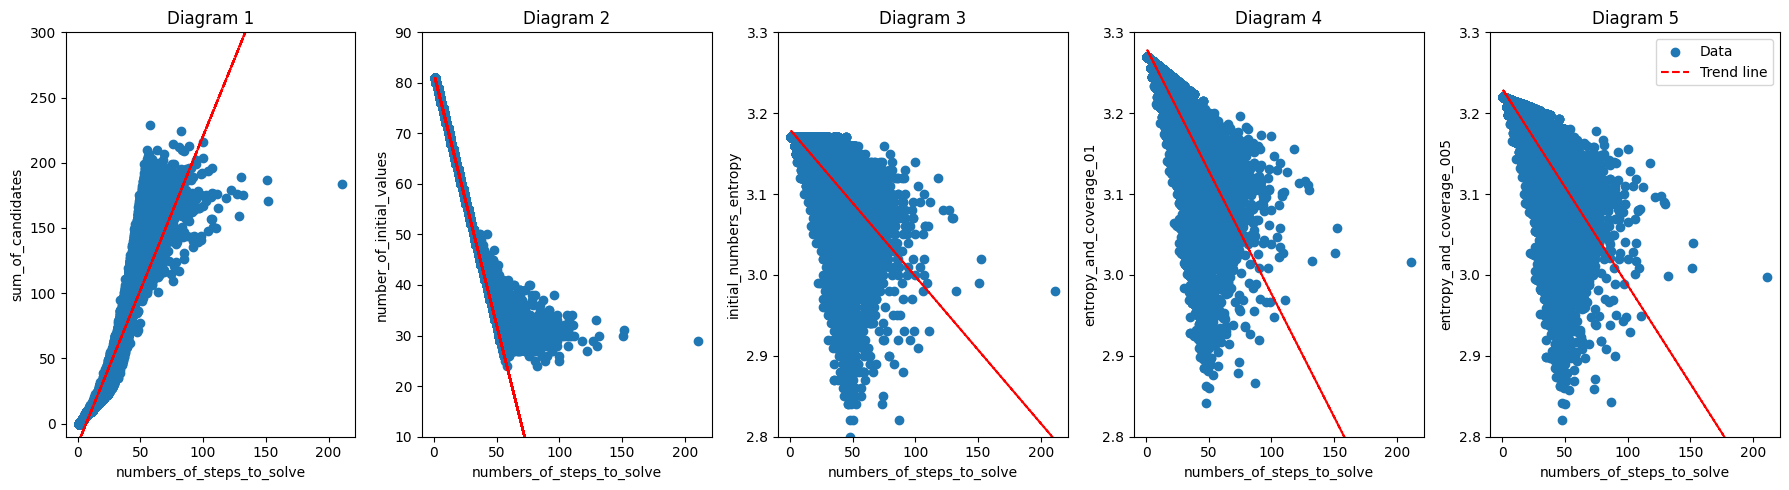

In [17]:
plt.figure(figsize=(18, 5))

# List of column names for plotting
columns = ['sum_of_candidates', 'number_of_initial_values', 'initial_numbers_entropy', 'entropy_and_coverage_01', 'entropy_and_coverage_005']

for i, column in enumerate(columns, 1):
    x = df_filtered['numbers_of_steps_to_solve']
    y = df_filtered[column]
    
    # Scatter plot
    plt.subplot(1, 5, i)
    plt.scatter(x, y, label='Data')
    
    # Fit and plot trend line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--", label='Trend line')  # "r--" is for red dashed line
    
    plt.title(f'Diagram {i}')
    plt.xlabel('numbers_of_steps_to_solve')
    plt.ylabel(column)
    ax = plt.gca()
    if i == 1:
        ax.set_ylim([-10, 300])
    elif i == 2:
        ax.set_ylim([10, 90])
    else:
        ax.set_ylim([2.8, 3.3])



plt.tight_layout()
plt.legend()
plt.show()

## Other

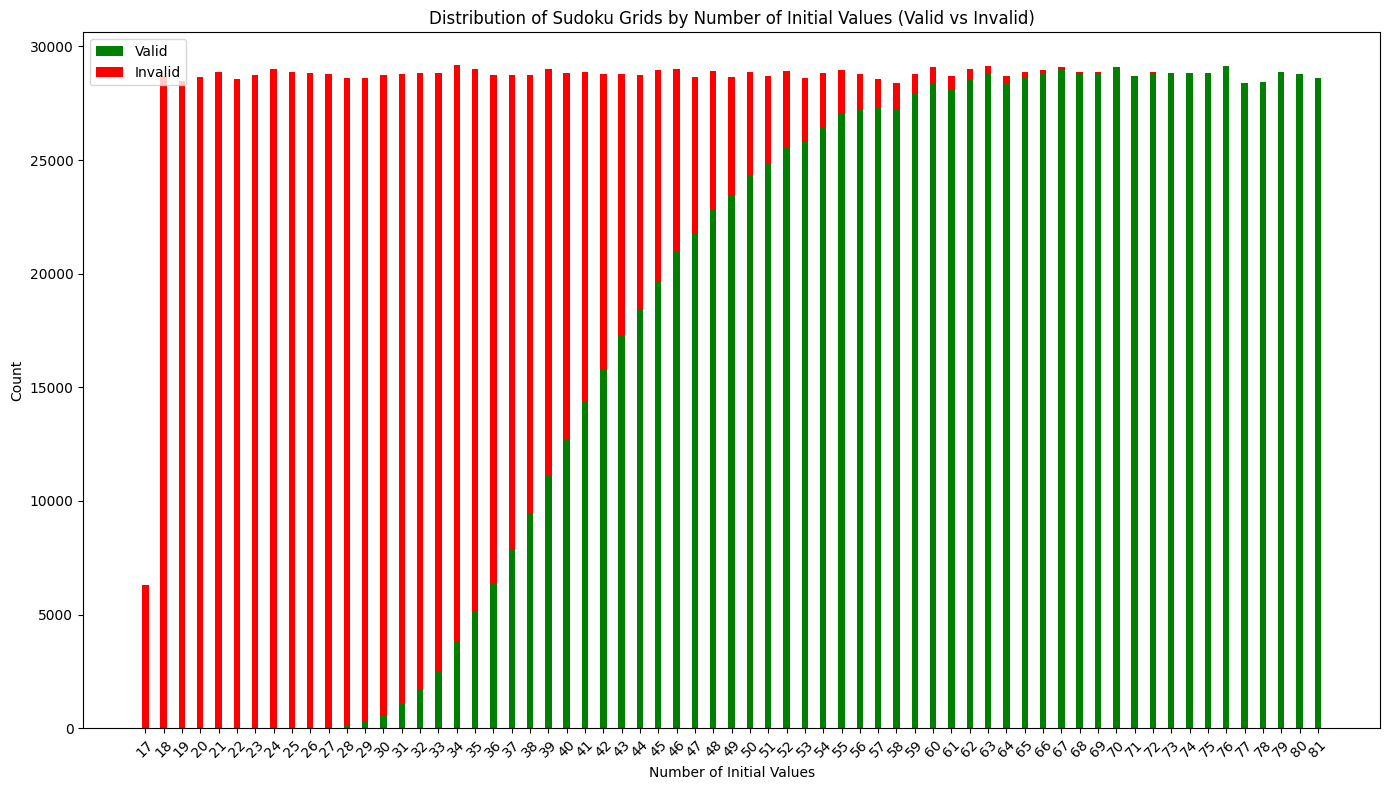

In [18]:
df['is_valid'] = df['numbers_of_steps_to_solve'] != -1

# Group by 'number_of_initial_values' to calculate counts
grouped = df.groupby('number_of_initial_values').agg(
    total_count=('number_of_initial_values', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

# Calculate invalid counts
grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

# Prepare the plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['number_of_initial_values']))

# Plotting the valid and invalid counts as stacked bars
bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Number of Initial Values')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Number of Initial Values (Valid vs Invalid)')
plt.xticks(index, grouped['number_of_initial_values'].astype(str), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

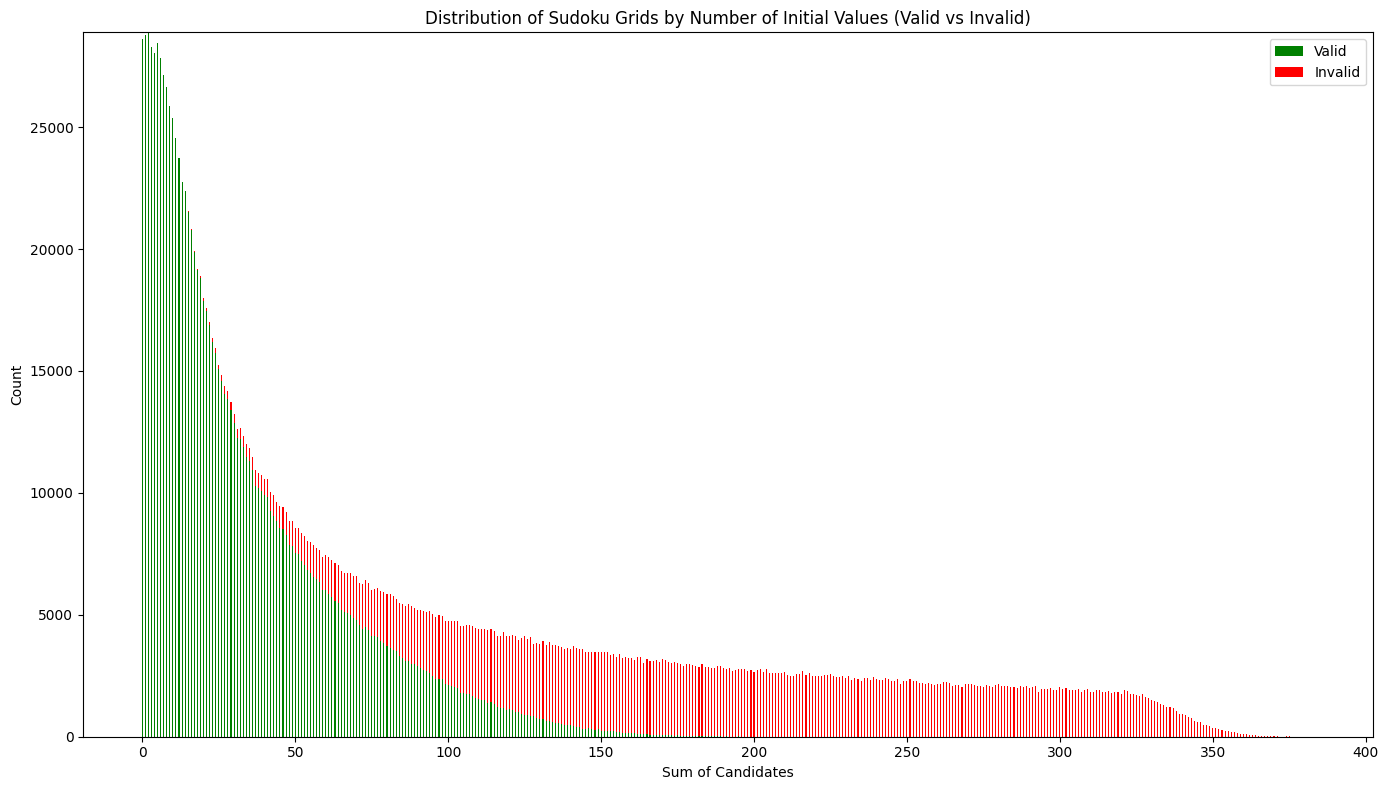

In [19]:
grouped = df.groupby('sum_of_candidates').agg(
    total_count=('sum_of_candidates', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

# Calculate invalid counts
grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

# Prepare the plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['sum_of_candidates']))

# Plotting the valid and invalid counts as stacked bars
bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Sum of Candidates')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Number of Initial Values (Valid vs Invalid)')
# plt.xticks(index, grouped['sum_of_candidates'].astype(str), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

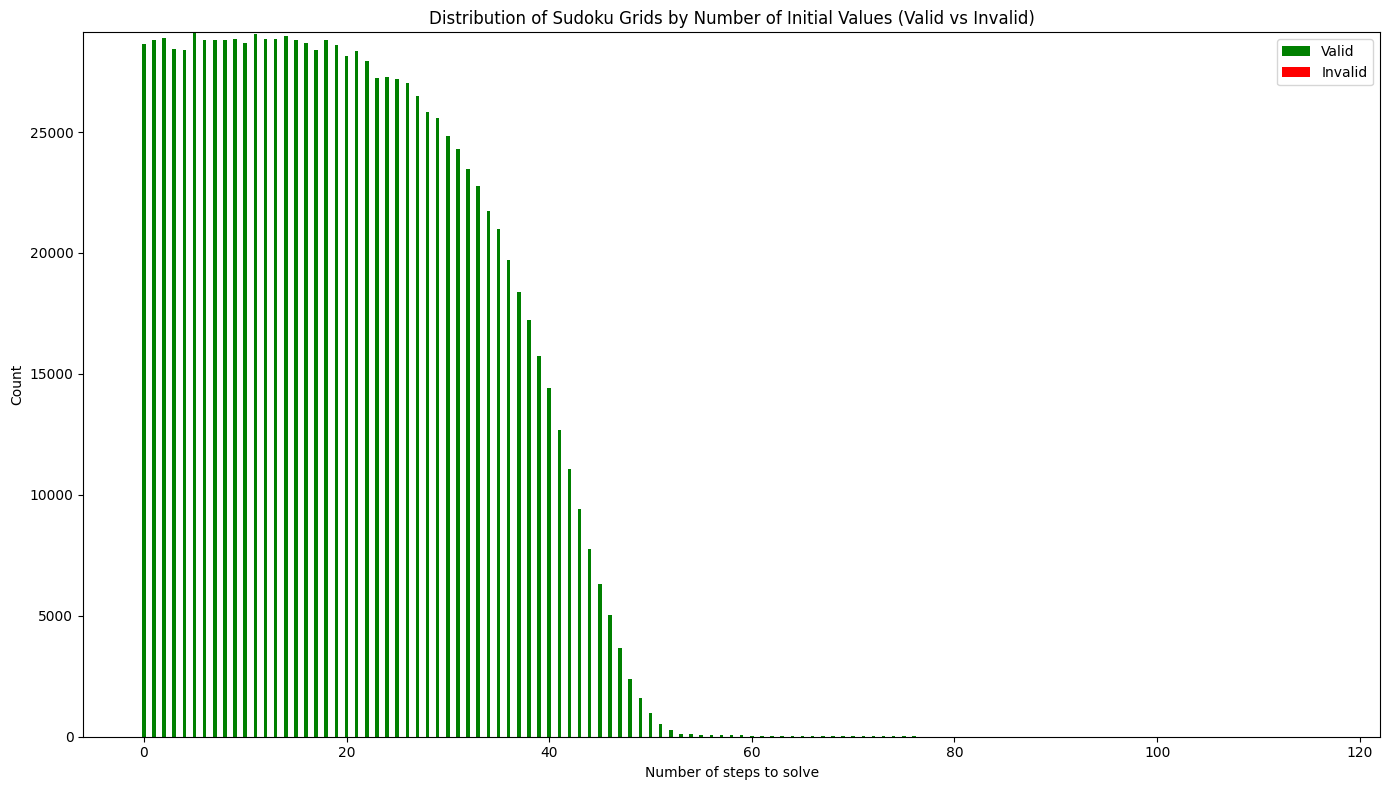

In [20]:
grouped = df[df['numbers_of_steps_to_solve'] != -1].groupby('numbers_of_steps_to_solve').agg(
    total_count=('numbers_of_steps_to_solve', 'size'),
    valid_count=('is_valid', 'sum')
).reset_index()

# Calculate invalid counts
grouped['invalid_count'] = grouped['total_count'] - grouped['valid_count']

# Prepare the plot
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(grouped['numbers_of_steps_to_solve']))

# Plotting the valid and invalid counts as stacked bars
bars_valid = plt.bar(index, grouped['valid_count'], bar_width, label='Valid', color='green')
bars_invalid = plt.bar(index, grouped['invalid_count'], bar_width, bottom=grouped['valid_count'], label='Invalid', color='red')

plt.xlabel('Number of steps to solve')
plt.ylabel('Count')
plt.title('Distribution of Sudoku Grids by Number of Initial Values (Valid vs Invalid)')
# plt.xticks(index, grouped['sum_of_candidates'].astype(str), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
df[df['numbers_of_steps_to_solve'] == -1].sort_values('number_of_initial_values', ascending = False)

,sum_of_candidates,number_of_initial_values,initial_numbers_entropy,numbers_of_steps_to_solve,is_valid
625748,9,76,3.16,-1,False
154681,10,75,3.16,-1,False
783176,10,75,3.16,-1,False
1550320,11,74,3.16,-1,False
39486,11,74,3.16,-1,False
...,...,...,...,...,...
1333722,348,17,3.06,-1,False
330806,332,17,3.01,-1,False
95092,337,17,3.01,-1,False
260050,347,17,2.98,-1,False


In [22]:
df_filtered.sort_values("numbers_of_steps_to_solve")

,sum_of_candidates,number_of_initial_values,initial_numbers_entropy,entropy_and_coverage_01,entropy_and_coverage_005,numbers_of_steps_to_solve
1089314,0,81,3.17,3.270000,3.220000,1
1423091,0,81,3.17,3.270000,3.220000,1
1040065,0,81,3.17,3.270000,3.220000,1
1040118,0,81,3.17,3.270000,3.220000,1
589188,0,81,3.17,3.270000,3.220000,1
...,...,...,...,...,...,...
890062,189,28,3.07,3.104568,3.087284,130
1371222,175,30,2.98,3.017037,2.998519,132
1837406,187,30,2.99,3.027037,3.008519,151
1190317,171,31,3.02,3.058272,3.039136,152
